## Data Prep

In [6]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.5 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 242 kB 71.9 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 39.5 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 28.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 26.2 MB/s eta 0:00:01
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 3.3 MB/s eta 0:00:01
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 249 kB 3.7 MB/s eta 0:00:01
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [84]:
data = pd.read_excel("owid-covid-data.xlsx")
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


In [85]:
# for this analysis, I will take new_cases from Italy
italy_data = data[data['location'] == "Italy"]
italy_data = italy_data[['date', 'new_cases']]
italy_data.set_index('date', inplace=True)
italy_data.index = pd.to_datetime(italy_data.index)
italy_data.head(10)

,new_cases
date,
2020-01-03,0.0
2020-01-04,0.0
2020-01-05,0.0
2020-01-06,0.0
2020-01-07,0.0
2020-01-08,0.0
2020-01-09,0.0
2020-01-10,0.0
2020-01-11,0.0


In [86]:
italy_data.shape

(1357, 1)

In [88]:
# ARIMA is senstive to missing values
# count and indices of missing values
missing_count = italy_data['new_cases'].isna().sum()
print(f"Count of missing values: {missing_count}")

missing_indices = italy_data[italy_data['new_cases'].isna()].index.tolist()
print(f"Indices of missing values: {missing_indices}")

Count of missing values: 6
Indices of missing values: [Timestamp('2023-09-15 00:00:00'), Timestamp('2023-09-16 00:00:00'), Timestamp('2023-09-17 00:00:00'), Timestamp('2023-09-18 00:00:00'), Timestamp('2023-09-19 00:00:00'), Timestamp('2023-09-20 00:00:00')]


In [89]:
# drop the last values as it may bias test performance
dates_to_drop = ['2023-09-15', '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19', '2023-09-20']
italy_data = italy_data.drop(pd.to_datetime(dates_to_drop))
italy_data.tail()

,new_cases
date,
2023-09-10,3835.0
2023-09-11,3066.0
2023-09-12,1548.0
2023-09-13,8510.0
2023-09-14,5918.0


In [90]:
# test train split 
train=italy_data.iloc[:-260 ]['new_cases']
test=italy_data.iloc[-260: ]['new_cases']
train = train.to_frame('new_cases')
test = test.to_frame('new_cases')
print(train.shape, test.shape)

(1091, 1) (260, 1)


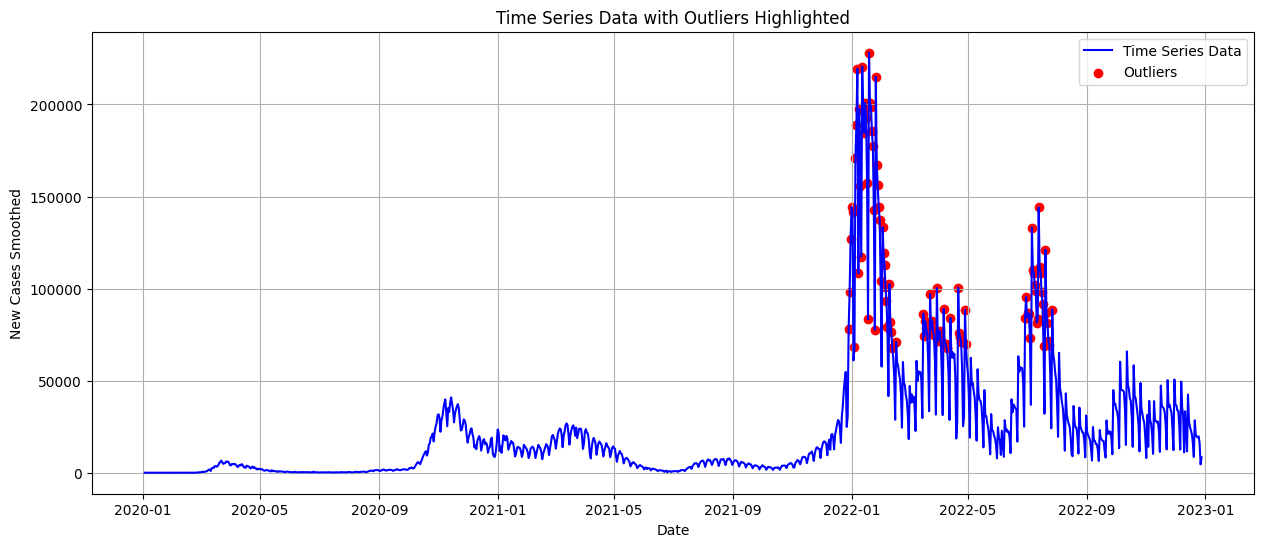

In [91]:
# ARIMA is sentive to outliers
Q1 = train['new_cases'].quantile(0.25)
Q3 = train['new_cases'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = train[(train['new_cases'] < lower_bound) | (train['new_cases'] > upper_bound)]

plt.figure(figsize=(15, 6))
plt.plot(train.index, train['new_cases'], label='Time Series Data', color='blue')
plt.scatter(outliers.index, outliers['new_cases'], color='red', label='Outliers')
plt.title('Time Series Data with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('New Cases Smoothed')
plt.legend()
plt.grid(True)
plt.show()


In [92]:
# cap the outliers at 100,000 to minimize impact of peaks
train['new_cases'] = train['new_cases'].apply(lambda x: 100000 if x > 100000 else x)
train.describe()

,new_cases
count,1091.000000
mean,20989.993584
std,26046.197829
min,0.000000
25%,2266.000000
50%,11628.000000
75%,28289.000000
max,100000.000000


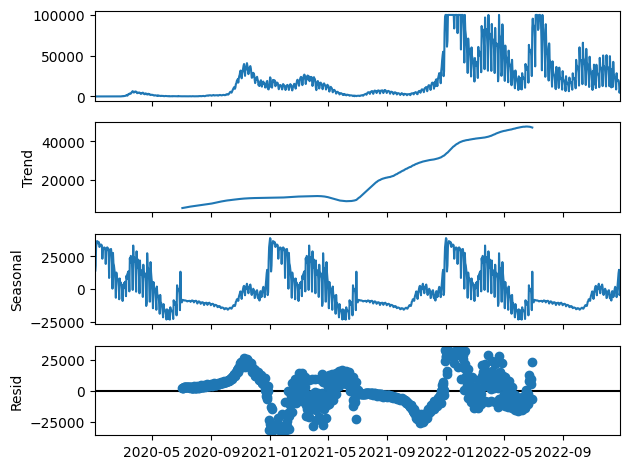

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(train, period=365).plot()
plt.show()

In [94]:
# test for stationarity
from statsmodels.tsa.stattools import adfuller

X = train.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.904305
p-value: 0.044850
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


The time series is stationary at the 5% significance level. This means that the time series doesn't exhibit trends or seasonality. I will start with d = 0 in the model. 

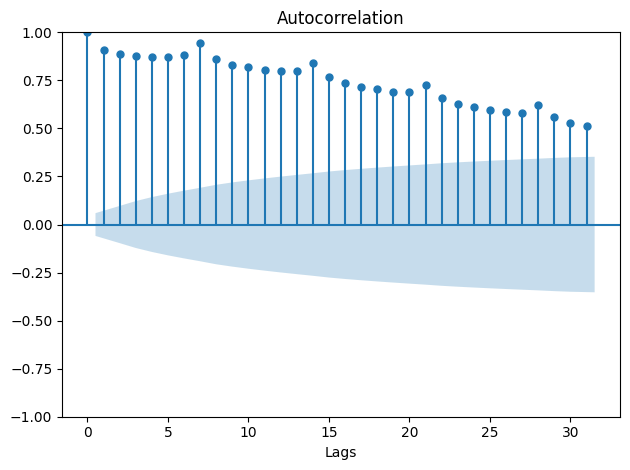

In [96]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
alpha=0.05
# Select a multiple of the seasonal frequency for the number of lags
plot_acf(train['new_cases'])
plt.xlabel('Lags')
plt.tight_layout()

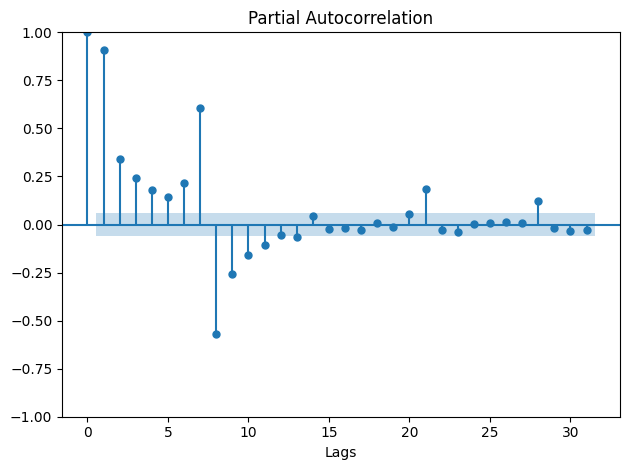

In [98]:
plot_pacf(train['new_cases'])
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

The ACF shows a gradual decline, indicating a higher order of autoregression. We observe significant correlations at the first few lags, followed by correlations that are not significant.	This indicates an autoregressive term in the data. I will start with 4 for the order of the autoregressive term.

## ARIMA

In [99]:
model = ARIMA(train, order=(4, 0, 2))
model=model.fit()

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/s

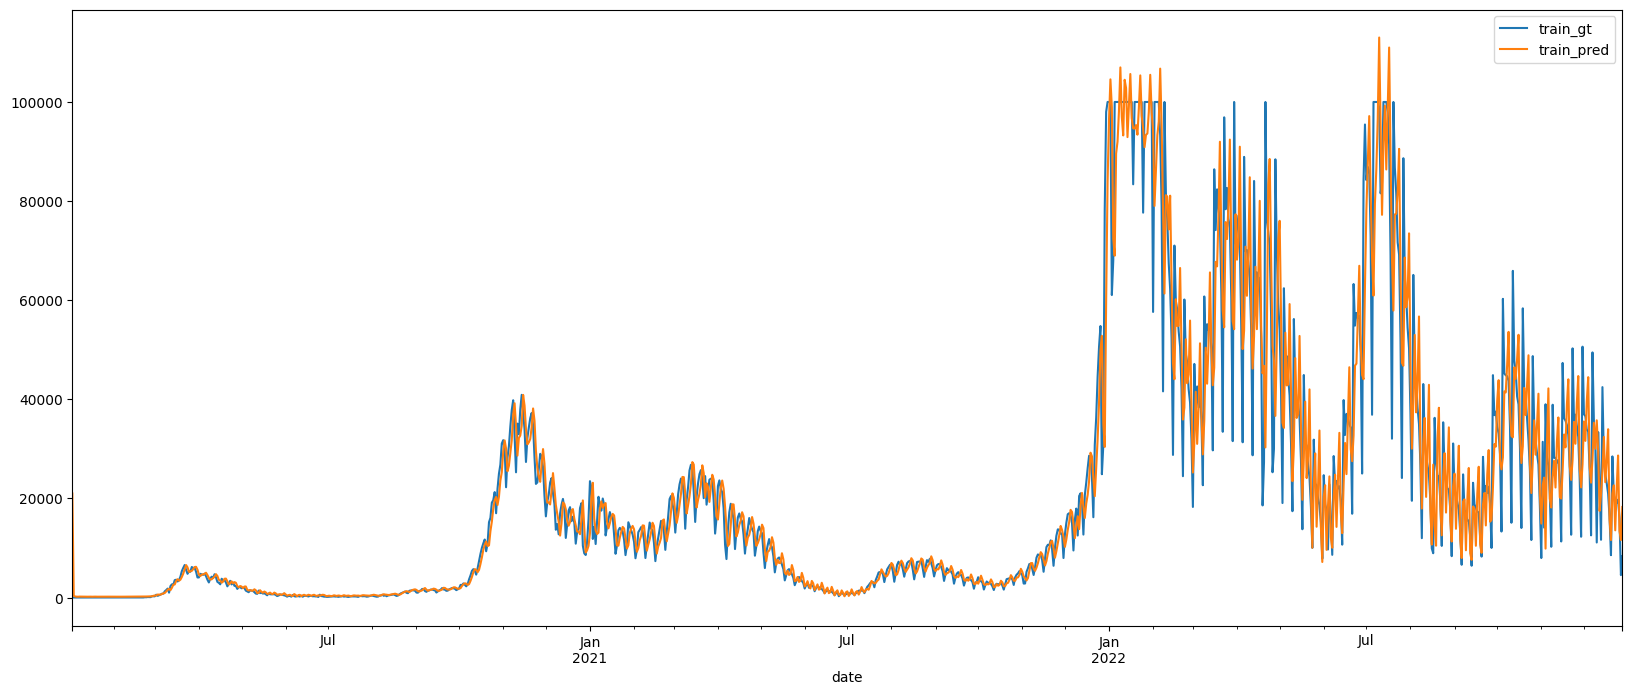

In [100]:
train_pred=model.fittedvalues
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

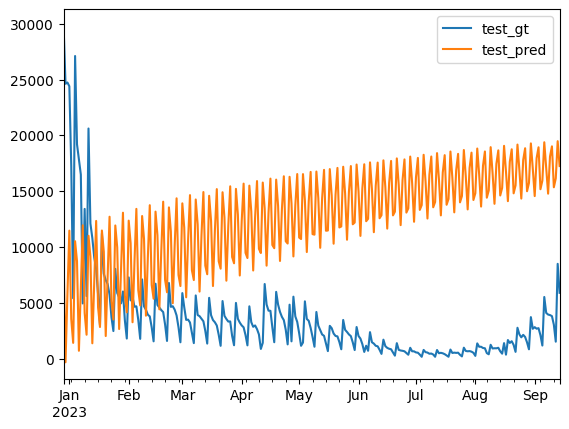

In [101]:
test_pred=model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
pd.concat([test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

In [102]:
train_rmse = np.sqrt(mean_squared_error(train, train_pred))
test_rmse = np.sqrt(mean_squared_error(test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 8814.696381334667
Test RMSE: 11766.689578133439


In [118]:
model2 = ARIMA(train, order=(2, 1, 0))
model2=model2.fit()

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


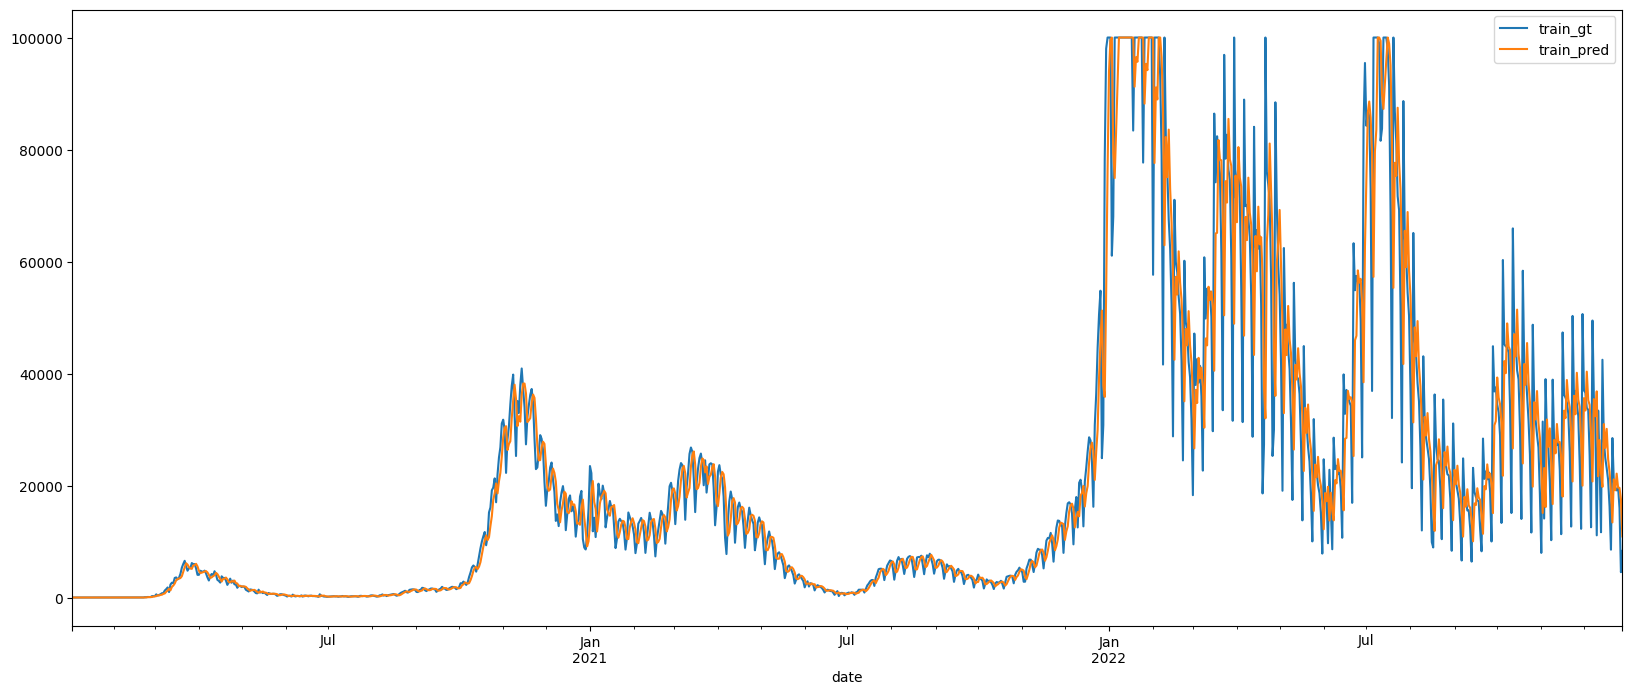

In [119]:
train_pred=model2.fittedvalues
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

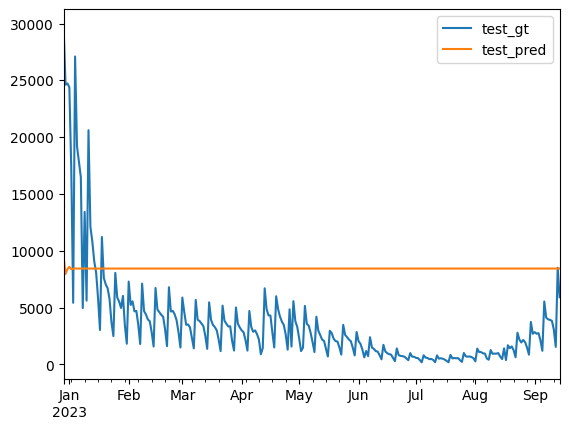

In [120]:
test_pred=model2.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
pd.concat([test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

In [113]:
train_rmse = np.sqrt(mean_squared_error(train, train_pred))
test_rmse = np.sqrt(mean_squared_error(test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 9573.125900265995
Test RMSE: 8446.276489518837


## Auto ARIMA

In [63]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [107]:
from pmdarima.arima import auto_arima
model_auto = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model_auto.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.95 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=23945.178, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=23572.471, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=23885.431, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=23471.528, Time=1.58 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.04 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.25 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=23564.655, Time=1.15 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=23332.566, Time=2.82 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=23481.569, Time=1.00 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.66 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=23278.308, Time=3.55 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

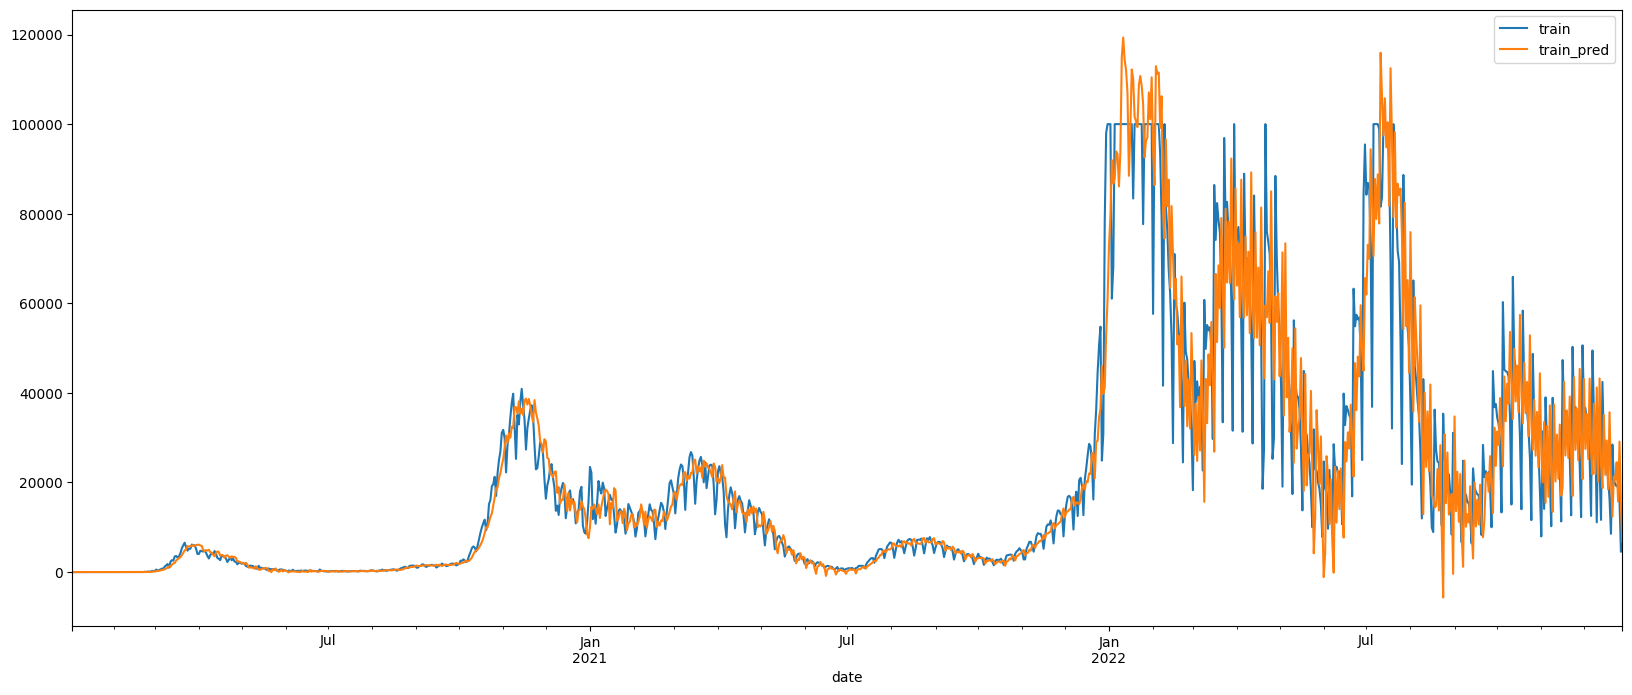

In [108]:
train_pred=model_auto.fittedvalues()
pd.concat([train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])

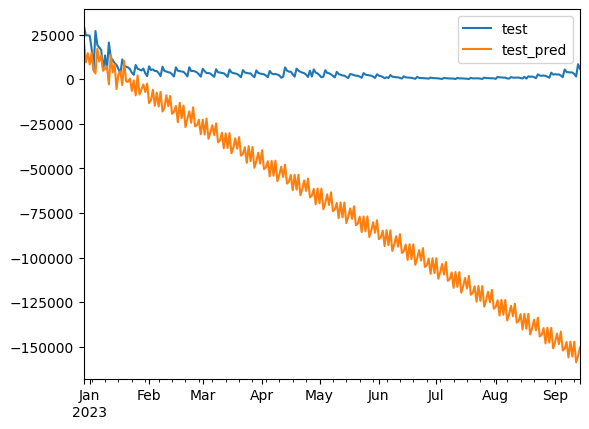

In [109]:
test_pred=model_auto.predict(n_periods=len(test))
pd.concat([test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])

??????????????????????